# User case: Belgica Bank time series

### Find Sentinel-1 data
Use the _SentinelAPI_ from _sentinelsat_ to find all Sentinel-1 imagery that covering a user-defined region of interest (ROI) in a given time period.
The ROI is defined as a polygon in a geojson file. Visit for "geojson.io" to create your own example.
The time period is hard-coded in the user-defined search parameters (starttime and endtime).


### Process the Sentinel-1 imagery
Use the Sentinel-1 name string to build the correct path to the location of the netcdf data on the met server. Load and calibrate HH and HV channel and visualize the data.


### Requirements
Requirement package are listed in "provision.sh".

In [1]:
# imports
import sys
from os import environ
from dotenv import load_dotenv
from loguru import logger

from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from dateparser import parse

import xarray as xr
import numpy as np

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed


In [2]:
# define loglevel
loglevel = 'INFO'
logger.remove()
logger.add(sys.stderr, level=loglevel)

1

### Copernicus scihub access

Use of the _sentinelAPI_ requires an account at _https://scihub.copernicus.eu/dhus/_. You can avoid hardcoding your scihub username and password in this notebook by using environment variables. To do this, create a file called ".env" with the following lines in the same folder as this notebook:

>DHUS_USER="your-scihub-username"  
>DHUS_PASSWORD="your-scihub-password"

__NB:__ Add the ".env" file to your ".gitignore" to avoid publishing it in your git repository!

In [3]:
# create environment variables stored in your ".env" file
load_dotenv()

# get copernicus.scihub username and password from environment variables
USERNAME = environ.get('DHUS_USER')
PASSWORD = environ.get('DHUS_PASSWORD')

# check that this was successful
if USERNAME == None:
    logger.error('USERNAME is: "None". Set variables correctly in ".env" file.')
if PASSWORD == None:
    logger.error('PASSWORD is: "None". Set variables correctly in ".env" file.')


### sentinelAPI search parameters

Define the search parameters for your query. The region of interest is defined as a polygon in geojson format. The _area_relation_ should be chosen depending on the size of your ROI and the specific needs of your project. For example, choose _Contains_ for a small ROI to ensure that the entire ROI is covered, or choose _Intersects_ for large ROIs to include all imagery that covers only parts of the ROI.

In [4]:
# define search parameters

# area and area relation
json_file = 'belgica_bank.geojson'
area_relation = 'Intersects'
##area_relation = 'Contains'

# time interval
starttime = parse('2022-04-01T00:00:00', settings={"DATE_ORDER": "YMD"})
endtime   = parse('2022-04-01T23:59:59', settings={"DATE_ORDER": "YMD"})

logger.debug(f'json_file:     {json_file}')
logger.debug(f'starttime:     {starttime}')
logger.debug(f'endtime:       {endtime}')
logger.debug(f'area_relatipn: {area_relation}')

In [5]:
# create Sentinel API
Sentinelapi = SentinelAPI(USERNAME, PASSWORD)

# query database
S1_result_dict = Sentinelapi.query(
    geojson_to_wkt(read_geojson(json_file)),
    date = (starttime,endtime),
    area_relation = area_relation,
    platformname = "Sentinel-1",
    producttype = "GRD"
)

In [6]:
n_imgs = len(S1_result_dict.keys())
logger.info(f'Found {n_imgs} Sentinel-1 images')
for i,key in enumerate(S1_result_dict.keys()):
    logger.info(f"Image {i+1}/{n_imgs}: {S1_result_dict[key]['title']}")

2023-02-02 21:39:03.751 | INFO     | __main__:<module>:2 - Found 2 Sentinel-1 images
2023-02-02 21:39:03.753 | INFO     | __main__:<module>:4 - Image 1/2: S1A_EW_GRDM_1SDH_20220401T075454_20220401T075554_042577_051429_AACB
2023-02-02 21:39:03.753 | INFO     | __main__:<module>:4 - Image 2/2: S1A_EW_GRDM_1SDH_20220401T075349_20220401T075454_042577_051429_E721


In [151]:
# select first hit
S1_base = S1_result_dict[list(S1_result_dict.keys())[0]]['title']

In [152]:
# get date info from S1 name string
S1_year  = S1_base.split('_')[4][0:4]
S1_month = S1_base.split('_')[4][4:6]
S1_day   = S1_base.split('_')[4][6:8]

# get S1 mode and sensor
S1_sensor = S1_base[0:3]
S1_mode   = S1_base.split('_')[1]

# build url and open data set
S1_url = f'https://nbstds.met.no/thredds/dodsC/NBS/{S1_sensor}/{S1_year}/{S1_month}/{S1_day}/{S1_mode}/{S1_base}.nc'
logger.debug(f'S1_url: {S1_url}')
S1_dst = xr.open_dataset(S1_url)

In [153]:
# connection to the server is very slow
# sub-step when loading data set
stride = 5

# HH
DN_HH        = S1_dst["Amplitude_HH"][0,::stride,::stride]
LUT_HH       = S1_dst["sigmaNought_HH"][0,::stride,::stride]
NOISE_LUT_HH = S1_dst["noiseCorrectionMatrix_HH"][0,::stride,::stride]

# HV
DN_HV        = S1_dst["Amplitude_HV"][0,::stride,::stride]
LUT_HV       = S1_dst["sigmaNought_HV"][0,::stride,::stride]
NOISE_LUT_HV = S1_dst["noiseCorrectionMatrix_HV"][0,::stride,::stride]

# lat/lon
lon = S1_dst['lon'][::stride,::stride]
lat = S1_dst['lat'][::stride,::stride]

# get image footprint
lon_min_geo = np.min(lon)
lon_max_geo = np.max(lon)
lat_min_geo = np.min(lat)
lat_max_geo = np.max(lat)

# this is faster, but not all S1 products have these attributes
##lon_min_geo = S1_dst.attrs['geospatial_lon_min']
##lat_min_geo = S1_dst.attrs['geospatial_lat_min']
##lon_max_geo = S1_dst.attrs['geospatial_lon_max']
##lat_max_geo = S1_dst.attrs['geospatial_lat_max']

logger.debug(f'lon_min: {lon_min_geo}')
logger.debug(f'lon_max: {lon_max_geo}')
logger.debug(f'lat_min: {lat_min_geo}')
logger.debug(f'lat_max: {lat_max_geo}')

In [154]:
# calibrate HH and HV channel and convert to dB

#sigma0_HH_denoise = (DN_HH**2 - NOISE_LUT_HH) / (LUT_HH**2)
#sigma0_HV_denoise = (DN_HV**2 - NOISE_LUT_HV) / (LUT_HV**2)
#sigma0_HH_dB_denoise = 10 * np.log10(sigma0_HH_denoise)
#sigma0_HV_dB_denoise = 10 * np.log10(sigma0_HV_denoise)

sigma0_HH    = (DN_HH**2) / (LUT_HH**2)
sigma0_HV    = (DN_HV**2) / (LUT_HV**2)
sigma0_HH_dB = 10 * np.log10(sigma0_HH)
sigma0_HV_dB = 10 * np.log10(sigma0_HV)



In [155]:
# find min/max percentiles for good visualization
vmin_HH = np.nanpercentile(sigma0_HH_dB, 0.5)
vmax_HH = np.nanpercentile(sigma0_HH_dB, 99.5)
vmin_HV = np.nanpercentile(sigma0_HV_dB, 0.1)
vmax_HV = np.nanpercentile(sigma0_HV_dB, 99.9)

logger.info(f'vmin_HH: {vmin_HH}')
logger.info(f'vmax_HH: {vmax_HH}')
logger.info(f'vmin_HV: {vmin_HV}')
logger.info(f'vmax_HV: {vmax_HV}')

2023-01-26 12:11:06.972 | INFO     | __main__:<module>:7 - vmin_HH: -24.03172492980957
2023-01-26 12:11:06.974 | INFO     | __main__:<module>:8 - vmax_HH: -0.9492515325546265
2023-01-26 12:11:06.974 | INFO     | __main__:<module>:9 - vmin_HV: -34.72173500061035
2023-01-26 12:11:06.975 | INFO     | __main__:<module>:10 - vmax_HV: -12.68703842163086


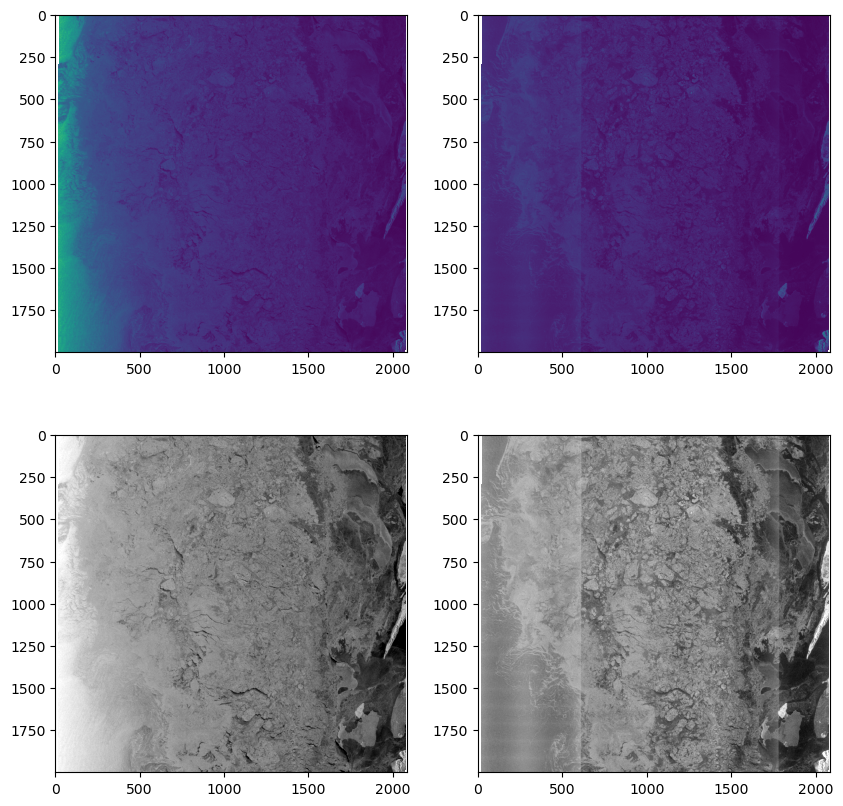

In [156]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
axes = axes.ravel()
axes[0].imshow(DN_HH)
axes[1].imshow(DN_HV)
axes[2].imshow(sigma0_HH_dB, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)
axes[3].imshow(sigma0_HV_dB, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)

In [157]:
# create 8-bit false_color RGB TODO
new_min = 0
new_max = 255

# linear map from sigma0 in dB to new_min and new_max
HH_scaled = (sigma0_HH_dB - (vmin_HH)) * ((new_max - new_min) / ((vmax_HH) - (vmin_HH))) + new_min
HV_scaled = (sigma0_HV_dB - (vmin_HV)) * ((new_max - new_min) / ((vmax_HV) - (vmin_HV))) + new_min

# clip values
HH_scaled = np.clip(HH_scaled, new_min, new_max)
HV_scaled = np.clip(HV_scaled, new_min, new_max)

# stack scaled channels to fals-color RGB
RGB = np.stack((HV_scaled,HH_scaled,HH_scaled),2)

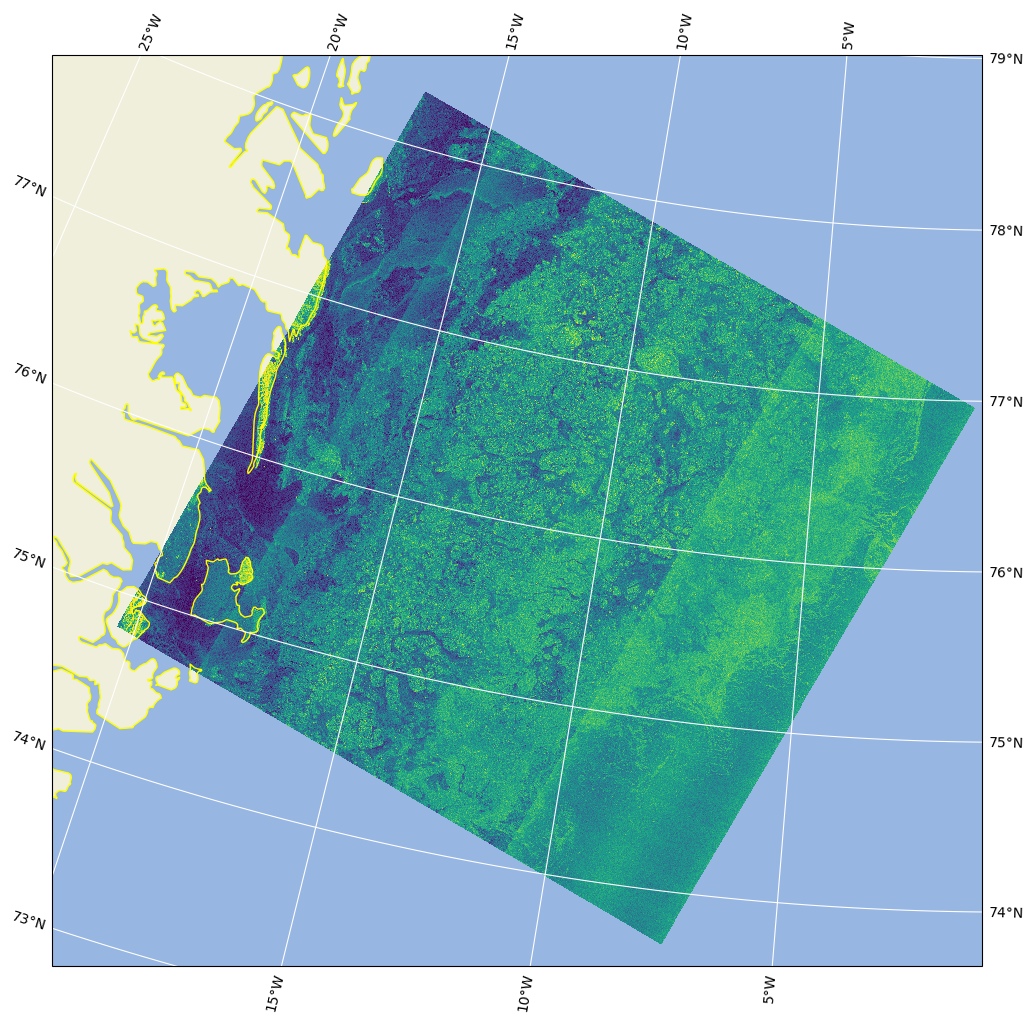

In [158]:
# define projections for the figure and the original set of coordinates
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

# create a figure handle
fig = plt.figure(figsize=(12,12))

# create an axes handle with the previously specified projection
ax = plt.axes(projection=target_projection)

# customise map and add features
ax.set_extent([lon_min_geo - 0,lon_max_geo + 0, lat_min_geo - 0, lat_max_geo + 0])

ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.gridlines(color='white',draw_labels=True, y_inline=False)
ax.coastlines(color='yellow')

color_tuple = RGB.transpose((1,0,2)).reshape((RGB.shape[0]*RGB.shape[1],RGB.shape[2]))/255.
plt.pcolormesh(lon, lat, RGB[:,:,0], color=color_tuple, transform=orig_projection, linewidth=0)
#plt.pcolormesh(lon, lat, sigma0_HV_dB, transform=orig_projection, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)

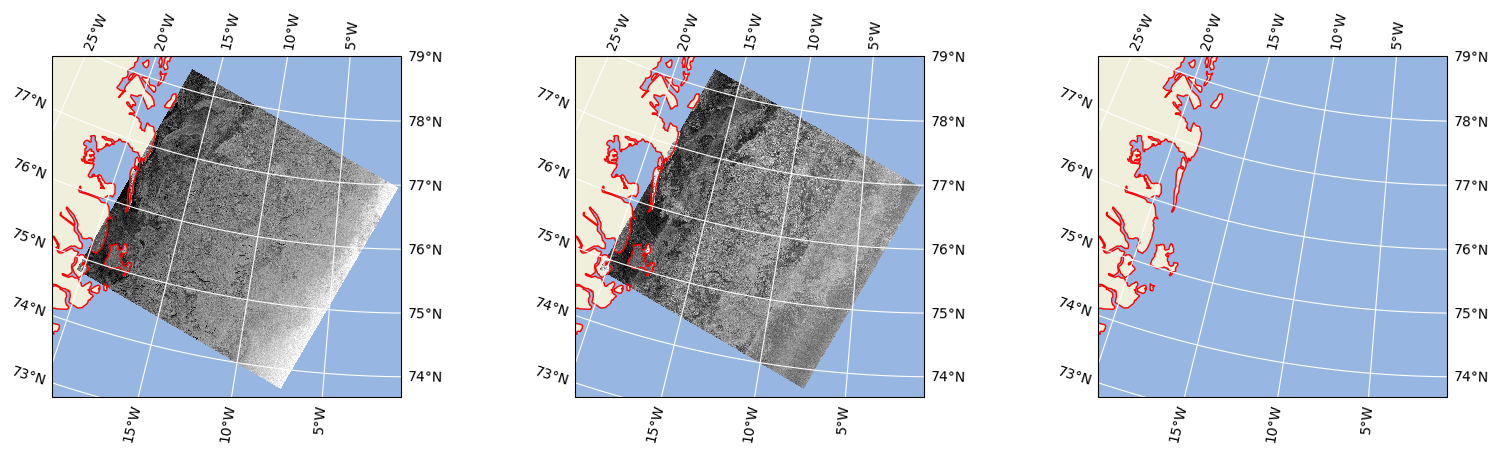

In [143]:
orig_projection = ccrs.PlateCarree()
target_projection = ccrs.Stereographic(central_longitude=0,central_latitude=60.)

fig, axes = plt.subplots(1,3, figsize=(18,6), subplot_kw={'projection': target_projection})
axes = axes.ravel()

axes[0].set_extent([lon_min_geo - 0,lon_max_geo + 0, lat_min_geo - 0, lat_max_geo + 0])
axes[0].add_feature(cartopy.feature.LAND)
axes[0].add_feature(cartopy.feature.OCEAN)
axes[0].gridlines(color='white',draw_labels=True, y_inline=False)
axes[0].coastlines(color='red',resolution='10m')
axes[0].pcolormesh(lon, lat, sigma0_HH_dB, transform=orig_projection, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)

axes[1].set_extent([lon_min_geo - 0,lon_max_geo + 0, lat_min_geo - 0, lat_max_geo + 0])
axes[1].add_feature(cartopy.feature.LAND)
axes[1].add_feature(cartopy.feature.OCEAN)
axes[1].gridlines(color='white',draw_labels=True, y_inline=False)
axes[1].coastlines(color='red',resolution='10m')
axes[1].pcolormesh(lon, lat, sigma0_HV_dB, transform=orig_projection, cmap='gray', vmin=vmin_HV, vmax=vmax_HV)

axes[2].set_extent([lon_min_geo - 0,lon_max_geo + 0, lat_min_geo - 0, lat_max_geo + 0])
axes[2].add_feature(cartopy.feature.LAND)
axes[2].add_feature(cartopy.feature.OCEAN)
axes[2].gridlines(color='white',draw_labels=True, y_inline=False)
axes[2].coastlines(color='red',resolution='10m')
#axes[2].pcolormesh(lon, lat, sigma0_HV_dB, transform=orig_projection, cmap='gray', vmin=vmin_HH, vmax=vmax_HH)

plt.subplots_adjust(left = None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

plt.savefig(f'{S1_base}_test_image.png', dpi=300)